cpu


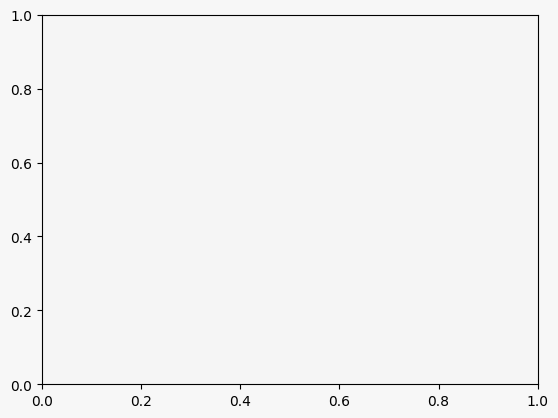

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader
import utils
from data_utils import CustomDataset
from MLP_utils import load_model, save_model, fix_seed, SimpleMLP, LNLoss
import os
import pandas as pd
import pickle

fix_seed(utils.SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

brands_in_csv_filename = [
    "ad",
    "brabantsdagblad",
    "destentor",
    "nu",
    "parool",
    "trouw",
    "volkskrant",
]

DIRPATH_EXTRACTED_FEATURES = "extracted_features"
DIRPATH_DATA = "Data"

plt.rcParams['figure.facecolor'] = (0.96862745, 0.96862745, 0.96862745) 
plt.gca().set_facecolor('whitesmoke')


plt.rcParams["figure.figsize"] = (6.8,7)
SMALL_SIZE = 10
MEDIUM_SIZE = 10
BIGGER_SIZE = 18
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
model, config = load_model('test2_with_features_config', device=device)

In [3]:
brands = utils.ALL_BRANDS


customdataset_kwargs = dict(
                        brands=brands, 
                        filenames_features=config["filenames_features"], 
                        dirpath_extracted_features=DIRPATH_EXTRACTED_FEATURES,
                        device=device,
                        log_target=True, 
                        center_target=True,
                        filter_uniform_features=False, 
                        max_datapoints=None)
try:
    dataset = CustomDataset(**customdataset_kwargs)
except torch.cuda.OutOfMemoryError as e:
    print("There was a torch.cuda.OutOfMemoryError. Proceeding with loading the data on the cpu.")
    customdataset_kwargs['device'] = torch.device('cpu')
    dataset = CustomDataset(**customdataset_kwargs)
    
dataset.features.shape[1], dataset.device

(3565, device(type='cpu'))

In [4]:
with open('train_dataset_indices.pkl', 'rb') as f:
    train_dataset_indices = pickle.load(f)

with open('val_dataset_indices.pkl', 'rb') as f:
    val_dataset_indices = pickle.load(f)

with open('test_dataset_indices.pkl', 'rb') as f:
    test_dataset_indices = pickle.load(f)

In [5]:
with torch.no_grad():
    model.eval()
    metric = nn.MSELoss(reduction='none')

    y_test = dataset[test_dataset_indices][1].cpu()
    y_pred_test = model(dataset[test_dataset_indices][0]).cpu()
    
    metric_score_test = metric(y_pred_test, y_test)
    metric_score_test = metric_score_test.squeeze()
    y_pred_test = y_pred_test.squeeze()

In [6]:
test_sort = torch.sort(metric_score_test, dim=0, descending=True)
test_sort_indices = torch.tensor(test_dataset_indices)[test_sort.indices]
test_sort_values = test_sort.values

test_pred = y_pred_test[test_sort.indices]
test_pred_hours = torch.exp(test_pred + dataset.centering_shift)

In [7]:
data_pd = pd.concat([pd.read_csv(os.path.join(DIRPATH_DATA, f"uva-relevance-windows-{brand_in_csv_filename}.csv"), sep=";")
                     for brand_in_csv_filename in brands_in_csv_filename], ignore_index=True)

In [8]:
# Amount of errors you want to see
n_errors = 5

# biggest n errors
biggest_errors = test_sort_values[:n_errors]
# smallest n errors
smallest_errors = test_sort_values[-n_errors:]

In [9]:
# predictions of n biggest errors
test_pred_hours[:n_errors]


tensor([ 10.7835,  14.5081,  15.6197,  16.5061, 152.1698])

In [10]:
# n articles with biggest error
data_pd.iloc[test_sort_indices[:n_errors]]

,article_id,brand,publication_timestamp,publication_weekday,title,first_paragraph,full_body,num_words,num_paragraphs,author_ids,labels,main_section,subsections,user_needs,lda_topics,iptc_topics_level_0,iptc_topics_level_1,time_indications_mentioned,relevance_window_in_hours
42511,b424d60,ad,2024-07-16 01:34:54+00:00,dinsdag,‘Musk wil 45 miljoen dollar per maand uitgeven...,Miljardair Elon Musk heeft gezegd dat hij van ...,Miljardair Elon Musk heeft gezegd dat hij van ...,125,4,['9359b390-c0a1-3100-b0fd-3426ddd2bb33'],NaN,nieuws,buitenland,"{'geef_me_context': 0.0003896642592735589, 'he...",{'afval_en_milieuproblematiek': 0.001096656895...,"{'politiek': 0.9903, 'wetenschap en technologi...","{'regering': 0.9379, 'sociale wetenschappen': ...",maandag,325.0
112374,e61103b,brabantsdagblad,2024-07-08 12:02:35+00:00,maandag,Pastoor Massaer weet niks van ongepaste appjes...,"De pastoor stuurde appjes met hakenkruizen, ma...","De pastoor stuurde appjes met hakenkruizen, ma...",483,12,['0a42b66d-c9c9-3740-a876-91f2a266ca70'],NaN,regio,hilvarenbeek,"{'geef_me_context': 0.007632475811988115, 'hel...",{'afval_en_milieuproblematiek': 0.018174177035...,"{'religie en geloof': 0.7471, 'kunst, cultuur,...","{'geloofssystemen': 0.7471, 'massa media': 0.6...","vrijdag,vorige week",436.0
183132,6329376,nu,2024-09-24 17:49:52+00:00,dinsdag,Terugkeer Bert Huisjes bij WNL toch nog niet z...,Het is toch nog niet zeker dat Bert Huisjes te...,Het is toch nog niet zeker dat Bert Huisjes te...,324,1,['cb4eacb2-3547-3efd-bbaa-092e294337bb'],"media,media en cultuur",media en cultuur,media,"{'geef_me_context': 0.0004486387479119003, 'he...",{'afval_en_milieuproblematiek': 0.000497034401...,"{'economie, zaken en financiën': 0.3733}",{'economische sector': 0.3733},"dinsdag,maandag",469.0
209759,b5de452,volkskrant,2024-08-31 22:30:27+00:00,zaterdag,Van acht neergestoken mensen bij ‘Notting Hell...,Twee mensen die vorige week werden aangevallen...,Twee mensen die vorige week werden aangevallen...,227,5,['cb417c05-0fc8-32ae-955f-ac1238c6d5a6'],nieuws,buitenland,NaN,"{'geef_me_context': 0.0004154244961682707, 'he...",{'afval_en_milieuproblematiek': 0.000706343329...,"{'politiek': 0.5008, 'misdaad, recht en gerech...","{'misdrijf': 0.5454, 'politie': 0.5127, 'vrije...","maandag,jaar,zondag,vorige week,zaterdag",466.0
107955,0f0b6a8c,brabantsdagblad,2024-06-14 14:45:59+00:00,vrijdag,Win kaarten voor Pinkpop,Proef het nieuwe speciaalbier “Brand Pinkpop”....,Proef het nieuwe speciaalbier “Brand Pinkpop”....,145,3,['ed4b8709-7c27-3cc1-89fe-31f8085a07c6'],NaN,NaN,NaN,"{'geef_me_context': 0.0004774731351062655, 'he...",{'afval_en_milieuproblematiek': 0.017873132601...,"{'levensstijl en vrije tijd': 0.8166, 'economi...","{'vrije tijd': 0.8166, 'economische sector': 0...","vrijdag,zaterdag",6.0


In [11]:
# predictions of n smallest errors
test_pred_hours[-n_errors:]

tensor([27.9954, 34.9975, 21.9990, 12.0003, 21.9997])

In [12]:
# n articles with smallest error
data_pd.iloc[test_sort_indices[-n_errors:]]

,article_id,brand,publication_timestamp,publication_weekday,title,first_paragraph,full_body,num_words,num_paragraphs,author_ids,labels,main_section,subsections,user_needs,lda_topics,iptc_topics_level_0,iptc_topics_level_1,time_indications_mentioned,relevance_window_in_hours
19443,0786ecb,ad,2024-06-03 08:10:44+00:00,maandag,Bij de escaperoom in het Vrijheidskwartier voe...,"Escape to Freedom, de nieuwe Escaperoom in het...","Escape to Freedom, de nieuwe Escaperoom in het...",424,12,['eaf06904-6453-396c-9b1a-9df4f65c4784'],NaN,regio,wageningen,"{'geef_me_context': 0.7026919722557068, 'help_...",{'afval_en_milieuproblematiek': 0.000427108490...,"{'religie en geloof': 0.4974, 'politiek': 0.39...","{'vrije tijd': 0.3869, 'fundamentele rechten':...",NaN,28.0
29617,0c474b8,ad,2024-06-20 16:01:02+00:00,donderdag,Andrew en Esther zetten horeca-avontuur te koo...,Alleen al de gedachte maakte Andrew en Esther ...,Alleen al de gedachte maakte Andrew en Esther ...,645,14,['d7276863-bfbf-390b-86e1-a3abfff4254b'],NaN,regio,hoeksche-waard,"{'geef_me_context': 0.0018063619500026107, 'he...",{'afval_en_milieuproblematiek': 0.000335818796...,"{'wetenschap en technologie': 0.6359, 'gezondh...",{'natuurwetenschap': 0.6359},NaN,35.0
76642,2228a6e,ad,2024-09-21 08:30:02+00:00,zaterdag,Ondernemers juichen een meer bruisend Eindhove...,EINDHOVEN - Waar horecabazen en culturele onde...,EINDHOVEN - Waar horecabazen en culturele onde...,523,12,['b8519cf9-1908-3249-a402-70f03bacab32'],NaN,regio,eindhoven,"{'geef_me_context': 0.031828947365283966, 'hel...",{'afval_en_milieuproblematiek': 0.000307527050...,"{'wetenschap en technologie': 0.838, 'gezondhe...","{'ziekten en aandoeningen': 0.5798, 'sociale w...","donderdag,donderdagavond",22.0
118873,7001487,brabantsdagblad,2024-08-15 08:55:35+00:00,donderdag,Vrouwen in India massaal de straat op voor art...,In het oosten van India zijn tienduizenden vro...,In het oosten van India zijn tienduizenden vro...,326,8,['9359b390-c0a1-3100-b0fd-3426ddd2bb33'],met video,nieuws,buitenland,"{'geef_me_context': 0.0003991103440057486, 'he...",{'afval_en_milieuproblematiek': 0.000465850724...,"{'conflict, oorlog en vrede': 0.7564, 'politie...","{'misdrijf': 1, 'wet': 0.7346, 'waarden': 0.6704}","dinsdag,vorige week",12.0
154018,a753cdd,destentor,2024-08-08 07:00:20+00:00,donderdag,Op Twente gestrande Russische Airbus gaat na v...,De Russische Airbus die al vier jaar lang op T...,De Russische Airbus die al vier jaar lang op T...,230,7,['86ceea84-5ddc-3425-9e3f-82e9023057a0'],NaN,regio,enschede,"{'geef_me_context': 0.0004193992353975773, 'he...",{'afval_en_milieuproblematiek': 0.000676450901...,"{'conflict, oorlog en vrede': 0.5, 'economie, ...","{'gewapend conflict': 0.5, 'economische sector...",NaN,22.0


In [13]:
# Full titles smallest errors
for title in data_pd.iloc[test_sort_indices[-n_errors:]]["title"]:
    print(title)

Bij de escaperoom in het Vrijheidskwartier voel je hoe het is om het verzet te zitten
Andrew en Esther zetten horeca-avontuur te koop via Marktplaats: ‘Je kunt er een toptent van maken’
Ondernemers juichen een meer bruisend Eindhoven toe, maar inwoners vrezen overlast: ‘Durf ook stille wijken in stand te houden’
Vrouwen in India massaal de straat op voor arts (31) die na dienst van 36 uur werd verkracht en vermoord
Op Twente gestrande Russische Airbus gaat na vier jaar weer vliegen


Error: 11.5995, True Value: 2.4124, Predicted: -0.9934, Index: 42511.0000
Error: 11.5800, True Value: 2.7062, Predicted: -0.6967, Index: 112374.0000
Error: 11.5741, True Value: 2.7792, Predicted: -0.6229, Index: 183132.0000
Error: 11.1586, True Value: 2.7727, Predicted: -0.5677, Index: 209759.0000
Error: 10.4538, True Value: -1.5797, Predicted: 1.6535, Index: 107955.0000
Error: 10.0631, True Value: 2.2984, Predicted: -0.8738, Index: 177181.0000
Error: 9.8704, True Value: 2.6544, Predicted: -0.4873, Index: 107428.0000
Error: 9.7306, True Value: 1.7933, Predicted: -1.3261, Index: 185068.0000
Error: 9.7136, True Value: 2.5896, Predicted: -0.5271, Index: 176411.0000
Error: 9.6802, True Value: 2.7641, Predicted: -0.3472, Index: 112581.0000
Error: 9.5335, True Value: 2.4779, Predicted: -0.6098, Index: 70428.0000
Error: 9.2904, True Value: -3.3715, Predicted: -0.3234, Index: 176558.0000
Error: 9.2338, True Value: 2.4634, Predicted: -0.5754, Index: 37938.0000
Error: 9.1429, True Value: 2.0312,

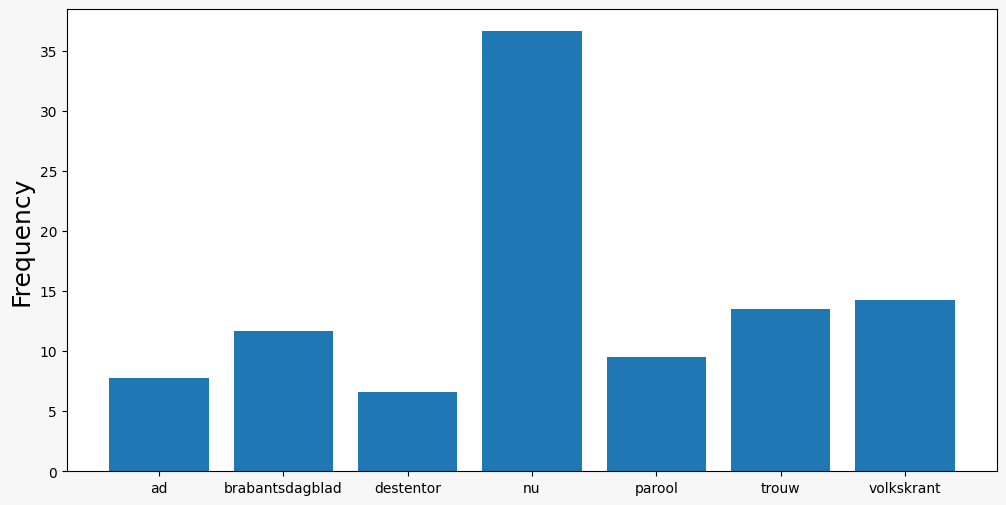

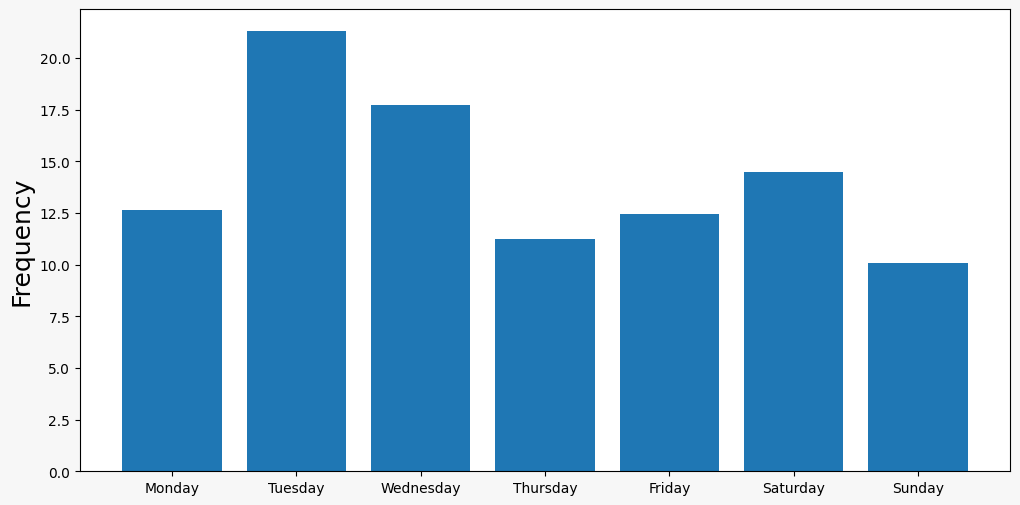

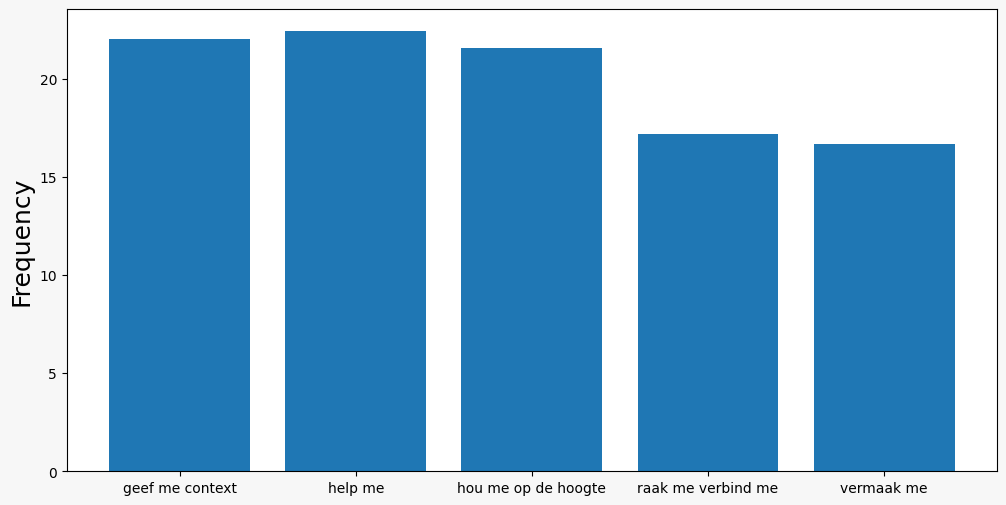

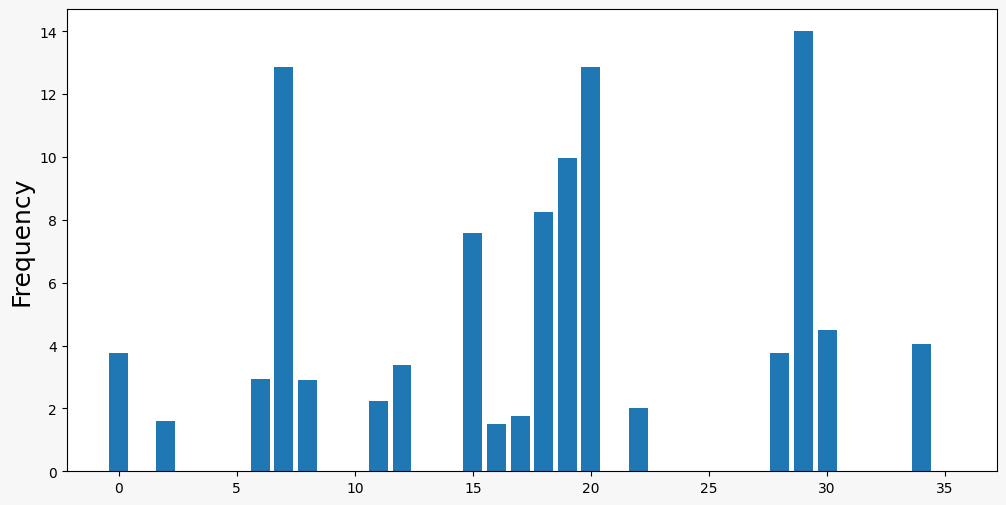

highest LDA frequency: veiligheid with 14.00211740195913 percentage


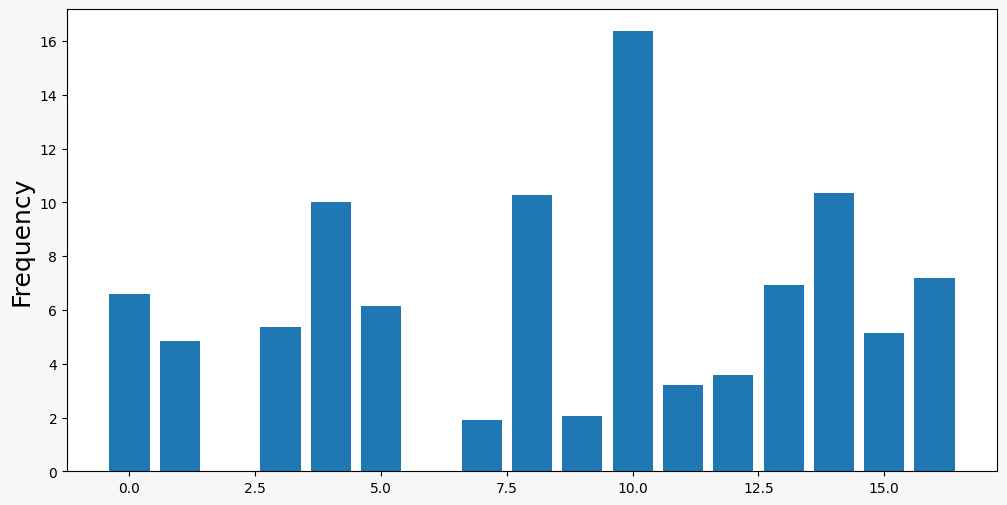

highest IPTC level 0 frequency: religie en geloof with 16.36966653786996 percentage


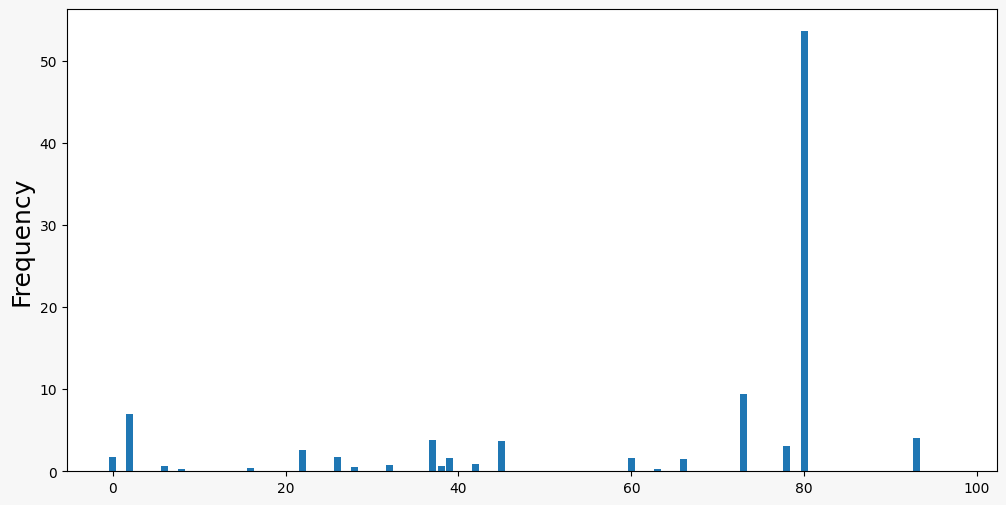

highest IPTC level 1 frequency: immigratie with 53.58090510235755 percentage


In [17]:
brands_in_csv_filename = [
    "ad",
    "brabantsdagblad",
    "destentor",
    "nu",
    "parool",
    "trouw",
    "volkskrant",
]
weekdays = [
	'Monday',
	'Tuesday',
	'Wednesday',
	'Thursday',
	'Friday',
	'Saturday',
	'Sunday'
]
user_needs=[
	'geef me context',
	'help me',
	'hou me op de hoogte',
	'raak me verbind me',
	'vermaak me'
]
LDA_topics = [
	'afval_en_milieuproblematiek', 
	'bestuur_en_organisatie',
	'bouwen_en_wonen',
	'brand',
	'consumeren_en_vrije_tijd',
	'duurzaamheid',
	'economie',
	'eten_en_drinken',
	'gemeentepolitiek',
	'gezondheid_en_zorg',
	'het_weer',
	'human_interest',
	'kunst_en_cultuur',
	'lokale_evenementen',
	'maatschappelijke_instellingen',
	'misdaad',
	'natuur',
	'nominatie_en_prijzen',
	'onderwijs',
	'optredens_en_voorstellingen',
	'overheidsbeleid',
	'politiek',
	'recht_en_justitie',
	'relatie_en_opvoeden',
	'religie',
	'samenleving',
	'sport',
	'technologie_en_handel',
	'vakbond_club_en_vereniging',
	'veiligheid',
	'verkeer',
	'verkeersongevallen',
	'voetbal',
	'wielrennen',
	'woon_en_leefomgeving',
	'zingeving_en_verhalen'
]

iptc_0_topics = [
	'economie, zaken en financiën',
	'sport',
	'misdaad, recht en gerechtigheid',
	'millieu',
	'het weer',
	'samenleving',
	'opleiding',
	'politiek',
	'arbeid',
	'conflict, oorlog en vrede',
	'religie en geloof',
	'levensstijl en vrije tijd',
	'menselijke interesse',
	'gezondheid',
	'ramp, ongeval en noodsituatie incident',
	'wetenschap en technologie',
	'kunst, cultuur, entertainment en media'
]

iptc_1_topics = ['wedstrijddiscipline', 'fundamentele rechten', 'mensheid', 'natuurwetenschap', 'cultuur', 'met pensioen', 'gezondheidsbehandeling', 'noodgeval', 'sociaal probleem', 'rechterlijke macht', 'technologie en techniek', 'wetenschappelijke instelling', 'demografie', 'markt en uitwisseling', 'sportorganisatie', 'overheidsgezondheidszorg', 'bedrijfsinformatie', 'natuur', 'religieus festival en vakantie', 'sociale wetenschappen', 'drugsgebruik in de sport', 'levensstijl', 'ziekten en aandoeningen', 'werk relaties', 'sport evenement', 'noodhulp', 'welzijn', 'godsdienstig onderwijs', 'familie', 'waarden', 'weersverschijnselen', 'ziektekostenverzekering', 'ongeval en noodgeval', 'bloemen en planten', 'economie', 'massa media', 'bloedbad', 'noodplanning', 'economische sector', 'toelatingsexamen', 'gemeenschappen', 'groep ouders', 'werkgelegenheid', 'werkloosheid', 'vakbonden', 'medisch beroep', 'weerswaarschuwing', 'wetenschappelijk onderzoek', 'maatschappelijke onrust', 'milieuvervuiling', 'gezondheidsfaciliteit', 'wiskunde', 'biomedische wetenschappen', 'religieuze leider', 'sociale conditie', 'politie', 'emigratie', 'ceremonie', 'internationale relaties', 'religieuze voorzieningen', 'kunst en vermaak', 'krijgsgevangenen', 'geloofssystemen', 'vredesproces', 'onderwijzen en leren', 'overheids beleid', 'discriminatie', 'sport industrie', 'gerechtigheid', 'sport transactie', 'gewapend conflict', 'weervoorspelling', 'disciplinaire maatregelen in de sport', 'ramp', 'terreurdaad', 'mensen', 'natuurlijke bronnen', 'klimaatverandering', 'gezondheidsorganisaties', 'wet', 'immigratie', 'school', 'politiek proces', 'dier', 'vrije tijd', 'misdrijf', 'leraren', 'verkiezing', 'leerplan', 'naoorlogse wederopbouw', 'educatieve testen en examens', 'arbeidswetgeving', 'studenten', 'religieuze tekst', 'sportlocatie', 'behoud', 'staatsgreep', 'regering']

errors = [(a.item(),b.numpy(),c.item(),d.item(), e) for (a,b,c,d,e) in zip(metric_score_test, dataset[test_dataset_indices][0].cpu(), y_test, y_pred_test, test_dataset_indices)]

errors.sort(reverse=True, key=lambda x: x[0])

brand_all_indices = [0 for _ in range(7)]
weekday_all_indices = [0 for _ in range(7)]
user_needs_all_indices = [0 for _ in range(5)]
LDA_all_indices = [0 for _ in range(36)]
iptc_0_all_indices = [0 for _ in range(17)]
iptc_1_all_indices = [0 for _ in range(98)]
for err in errors[:220000]:
	brand_all_index, _ = max(enumerate(err[1][0:7]), key=lambda x: x[1])
	brand_all_indices[brand_all_index] += 1
	weekday_all_index, _ = max(enumerate(err[1][8:15]), key=lambda x: x[1])
	weekday_all_indices[weekday_all_index] += 1
	user_needs_all_index, _ = max(enumerate(err[1][317:322]), key=lambda x: x[1])
	user_needs_all_indices[user_needs_all_index] += 1
	LDA_all_index, _ = max(enumerate(err[1][322:358]), key=lambda x: x[1])
	LDA_all_indices[LDA_all_index] += 1
	iptc_0_all_index, _ = max(enumerate(err[1][358:375]), key=lambda x: x[1])
	iptc_0_all_indices[iptc_0_all_index] += 1
	iptc_1_all_index, _ = max(enumerate(err[1][375:473]), key=lambda x: x[1])
	iptc_1_all_indices[iptc_1_all_index] += 1

brand_max_indices = [0 for _ in range(7)]
weekday_max_indices = [0 for _ in range(7)]
user_needs_max_indices = [0 for _ in range(5)]
LDA_max_indices = [0 for _ in range(36)]
iptc_0_max_indices = [0 for _ in range(17)]
iptc_1_max_indices = [0 for _ in range(98)]

for err in errors[:100]:
	print(f"Error: {err[0]:.4f}, True Value: {err[2]:.4f}, Predicted: {err[3]:.4f}, Index: {err[4]:.4f}")
	brand_max_index, _ = max(enumerate(err[1][0:7]), key=lambda x: x[1])
	brand_max_indices[brand_max_index] += 1
	weekday_max_index, _ = max(enumerate(err[1][8:15]), key=lambda x: x[1])
	weekday_max_indices[weekday_max_index] += 1
	user_needs_max_index, _ = max(enumerate(err[1][317:322]), key=lambda x: x[1])
	user_needs_max_indices[user_needs_max_index] += 1
	LDA_max_index, _ = max(enumerate(err[1][322:358]), key=lambda x: x[1])
	LDA_max_indices[LDA_max_index] += 1
	iptc_0_max_index, _ = max(enumerate(err[1][358:375]), key=lambda x: x[1])
	iptc_0_max_indices[iptc_0_max_index] += 1
	iptc_1_max_index, _ = max(enumerate(err[1][375:473]), key=lambda x: x[1])
	iptc_1_max_indices[iptc_1_max_index] += 1


brand_max_indices = [brand_max_indices[i] / brand_all_indices[i] for i in range(7)]
weekday_max_indices = [weekday_max_indices[i] / weekday_all_indices[i] for i in range(7)]
user_needs_max_indices = [user_needs_max_indices[i] / user_needs_all_indices[i] for i in range(5)]
LDA_max_indices = [LDA_max_indices[i] / LDA_all_indices[i] if LDA_all_indices[i] != 0 else 0 for i in range(36)]
iptc_0_max_indices = [iptc_0_max_indices[i] / iptc_0_all_indices[i] if iptc_0_all_indices[i] != 0 else 0 for i in range(17)]
iptc_1_max_indices = [iptc_1_max_indices[i] / iptc_1_all_indices[i] if iptc_1_all_indices[i] != 0 else 0 for i in range(98)]

brand_max_indices = [(brand_max_indices[i] / sum(brand_max_indices)) * 100 for i in range(7)]
weekday_max_indices = [(weekday_max_indices[i] / sum(weekday_max_indices)) * 100 for i in range(7)]
user_needs_max_indices = [(user_needs_max_indices[i] / sum(user_needs_max_indices)) * 100 for i in range(5)]
LDA_max_indices = [(LDA_max_indices[i] / sum(LDA_max_indices)) * 100 for i in range(36)]
iptc_0_max_indices = [(iptc_0_max_indices[i] / sum(iptc_0_max_indices)) * 100 for i in range(17)]
iptc_1_max_indices = [(iptc_1_max_indices[i] / sum(iptc_1_max_indices)) * 100 for i in range(98)]

plt.figure(figsize=(12, 6))
plt.ylabel('Frequency')
plt.bar(brands_in_csv_filename, brand_max_indices)
plt.show()

weekday_max_indices_s = weekday_max_indices[-2:] + weekday_max_indices[:-2]
plt.figure(figsize=(12, 6))
plt.ylabel('Frequency')
plt.bar(weekdays, weekday_max_indices_s)
plt.show()

plt.figure(figsize=(12, 6))
plt.ylabel('Frequency')
plt.bar(user_needs, user_needs_max_indices)
plt.show()

plt.figure(figsize=(12, 6))
plt.ylabel('Frequency')
plt.bar([i for i in range(36)], LDA_max_indices)
plt.show()

highest_LDA = max(LDA_max_indices)
index_highest_LDA = LDA_max_indices.index(highest_LDA)
print(f"highest LDA frequency: {LDA_topics[index_highest_LDA]} with {LDA_max_indices[index_highest_LDA]} percentage")

plt.figure(figsize=(12, 6))
plt.ylabel('Frequency')
plt.bar([i for i in range(17)], iptc_0_max_indices)
plt.show()

highest_iptc_0 = max(iptc_0_max_indices)
index_highest_iptc_0 = iptc_0_max_indices.index(highest_iptc_0)
print(f"highest IPTC level 0 frequency: {iptc_0_topics[index_highest_iptc_0]} with {iptc_0_max_indices[index_highest_iptc_0]} percentage")

plt.figure(figsize=(12, 6))
plt.ylabel('Frequency')
plt.bar([i for i in range(98)], iptc_1_max_indices)
plt.show()

highest_iptc_1 = max(iptc_1_max_indices)
index_highest_iptc_1 = iptc_1_max_indices.index(highest_iptc_1)
print(f"highest IPTC level 1 frequency: {iptc_1_topics[index_highest_iptc_1]} with {iptc_1_max_indices[index_highest_iptc_1]} percentage")